# Analyse du jeu de données TAWOS

> 13 référentiels open source ont été extrait : Apache, Appcelerator, Atlassian, DNNSoftware, Hyperledger, Lsstcorp, Lyrasis DuraSpace, MongoDB, Moodle, MuleSoft, Spring, Sonatype et Talendforge.

La plupart de ces référentiels ont été utilisés dans le cadre de travaux antérieurs et **tous utilisent Jira comme plateforme de gestion des problèmes**,
ce qui garantit l'uniformité de la structure et la disponibilité des informations. Dans chacun de ces référentiels, des projets ont été sélectionnés de manière à ce qu'ils adoptent un développement itératif et une **gestion des problèmes**.

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [2]:
load_dotenv()

# Informations de la base de données SQL contenant le jeux de données TAWOS
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
database = os.getenv("DB_DATABASE")

## Connexion à la base de données SQL (TAWOS)

In [3]:
engine = create_engine(
    f"mariadb+mysqldb://{user}:{password}@{host}:{port}/{database}"
)

issue = pd.read_sql_table("Issue", engine) # "ID", "Title", "Description", "Status", "Resolution", "Last_Updated"
comment = pd.read_sql_table("Comment", engine) # "Issue_ID", "Comment"

## Filtrage des issues provenant du projet MongoDB Core Server

> ID : 33 <br>
> Description : MongoDB Enterprise Server est l'édition commerciale de MongoDB, disponible dans le cadre de l'abonnement MongoDB Enterprise Advanced.

In [7]:
issue_mongodb = issue[issue['Project_ID'] == 33]

## Analyse des Issues

In [8]:
print(f"Nombre d'issues : {issue_mongodb.shape[0]}")
print(f"Nombre de features dans la table 'Issue' : {issue_mongodb.shape[1]}")

Nombre d'issues : 48663
Nombre de features dans la table 'Issue' : 30


### Type des issues

In [9]:
issue_mongodb.dtypes

ID                                               int64
Jira_ID                                          int64
Issue_Key                                       object
URL                                             object
Title                                           object
Description                                     object
Description_Text                                object
Description_Code                                object
Type                                            object
Priority                                        object
Status                                          object
Resolution                                      object
Creation_Date                           datetime64[ns]
Estimation_Date                         datetime64[ns]
Resolution_Date                         datetime64[ns]
Last_Updated                            datetime64[ns]
Story_Point                                    float64
Timespent                                      float64
In_Progres

In [10]:
issue_reduce = issue_mongodb[["ID", "Title", "Description", "Type", "Status", "Resolution", "Last_Updated"]]
issue_clean = issue_reduce.dropna()
print(issue_clean.shape)
issue_clean.head()

(43838, 7)


,ID,Title,Description,Type,Status,Resolution,Last_Updated
409585,460389,"""Architecture Guide updates for Close feature ...","""Please investigate if this project requires c...",Task,Closed,Won't Fix,2020-10-21 14:30:27
409594,460398,"""libunwind fails to build with GCC >=10.2""","""In the newer GCC version, C globals are now n...",Bug,Closed,Fixed,2020-10-21 02:03:04
409598,460402,"""Handle retryable writes in resharding oplog a...",,Task,Closed,Duplicate,2020-10-20 17:56:52
409599,460403,"""Handle transactions in resharding oplog applier""",,Task,Closed,Duplicate,2020-10-20 17:56:47
409605,460409,"""Fix 3-way compare for ArraySet in SBE""",,Bug,Closed,Fixed,2020-10-21 07:29:02


In [11]:
type_values = issue_clean["Type"].value_counts()
type_values

Type
Bug            21456
Task            9894
Improvement     9148
New Feature     2016
Question        1324
Name: count, dtype: int64

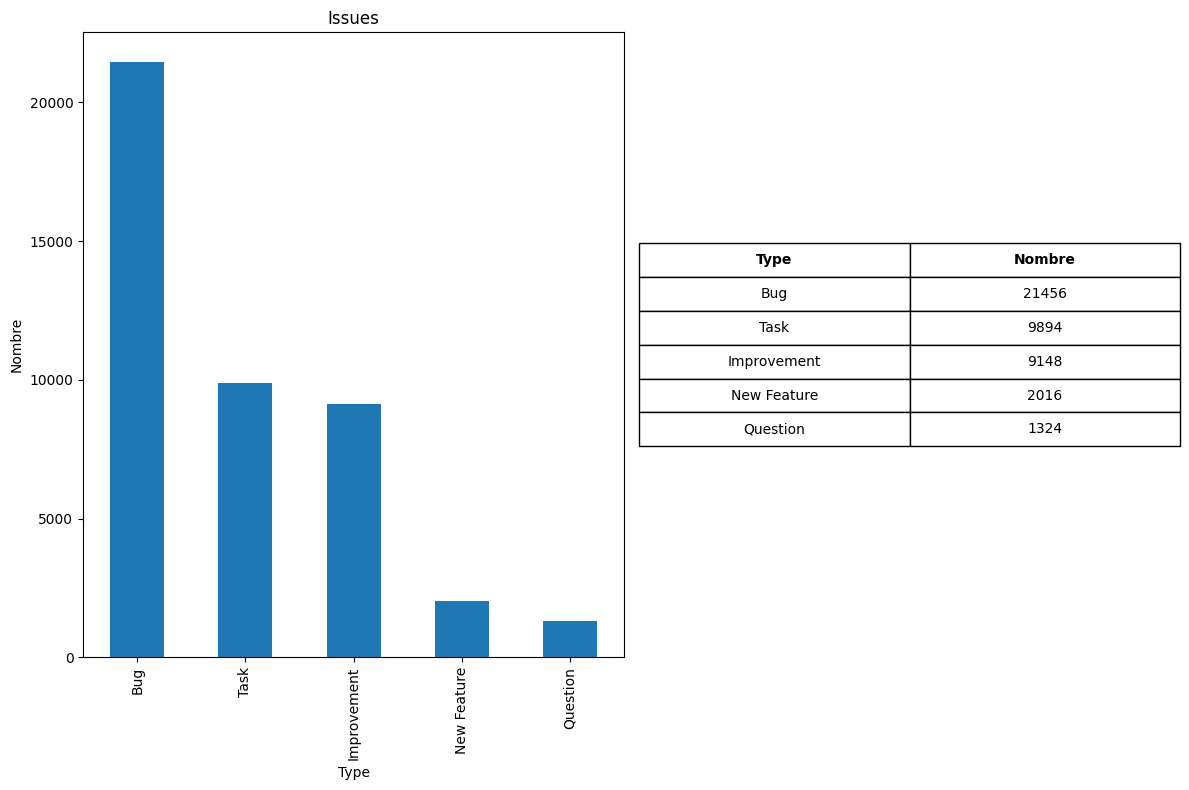

In [12]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
type_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=type_values.reset_index().values,
                  colLabels=['Type', 'Nombre'],
                  cellLoc='center',
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("types_issues.png")
plt.show()

Les types d'issues que l'on va conserver sont :
- Bug
- Question                         

In [13]:
issue_clean_type = issue_clean[(issue_clean["Type"] == "Bug") | (issue_clean["Type"] == "Question")]
issue_clean_type.shape

(22780, 7)

### Status des issues

In [14]:
issue_clean_type["Status"].unique()

array(['Closed'], dtype=object)

In [15]:
status_values = issue_clean_type["Status"].value_counts()
status_values

Status
Closed    22780
Name: count, dtype: int64

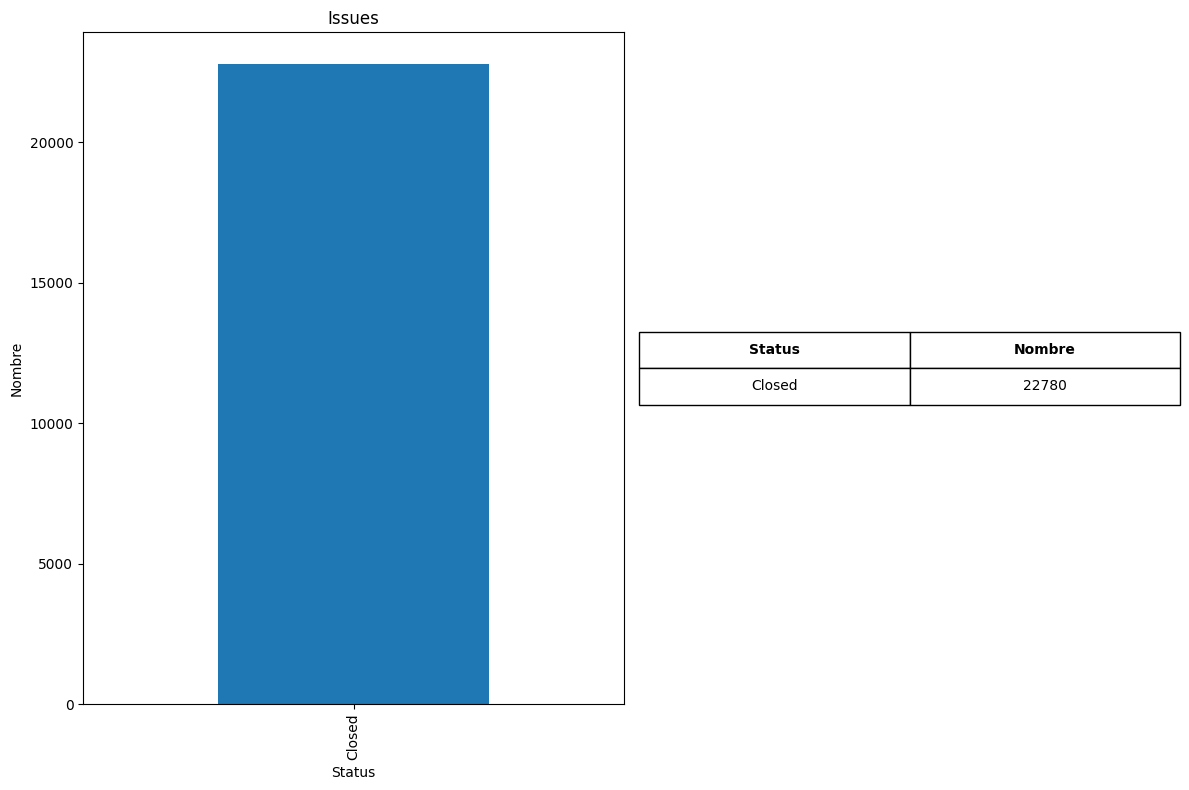

In [17]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 2, width_ratios=[1, 1])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
status_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=status_values.reset_index().values,
                  colLabels=['Status', 'Nombre'],
                  cellLoc='center',
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("status_issues.png")
plt.show()

Il n'y a plus qu'un seul status :
- Closed

### Résolution des issues

In [19]:
issue_clean_type["Resolution"].unique()

array(['Fixed', 'Community Answered', 'Duplicate', 'Done',
       'Works as Designed', "Won't Fix", "Won't Do", 'Gone away',
       'Incomplete', 'Cannot Reproduce', 'Declined'], dtype=object)

In [20]:
resolution_values = issue_clean_type["Resolution"].value_counts()
resolution_values

Resolution
Fixed                 12948
Duplicate              3069
Works as Designed      1841
Done                   1428
Gone away              1157
Won't Fix              1003
Incomplete              692
Cannot Reproduce        520
Community Answered       65
Won't Do                 55
Declined                  2
Name: count, dtype: int64

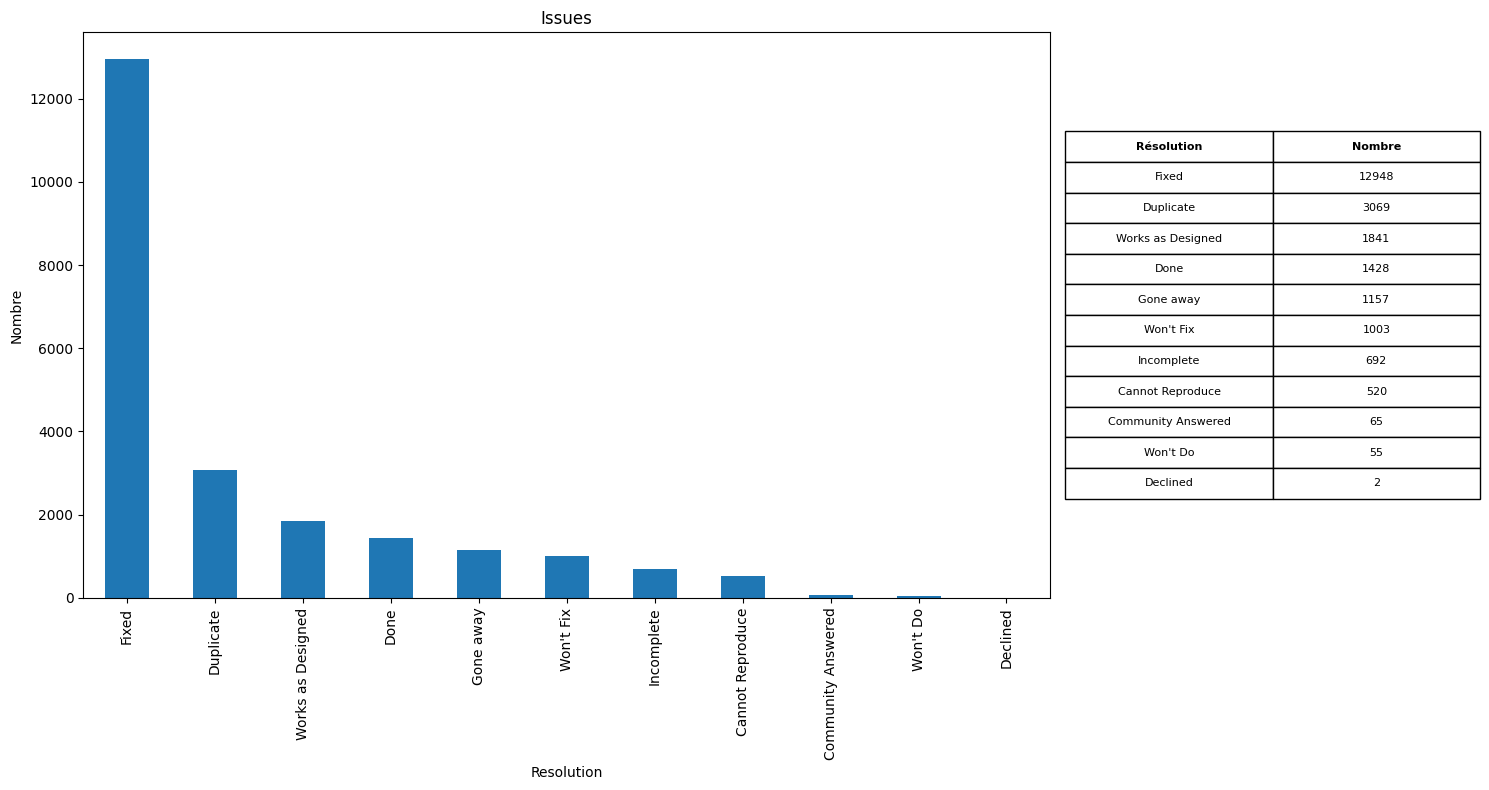

In [21]:
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(1, 2, width_ratios=[0.7, 0.3])

# Premier sous-graphe : le graphique à barres
ax1 = fig.add_subplot(gs[0])
resolution_values.plot(kind='bar', ax=ax1)
ax1.set_title("Issues")
ax1.set_ylabel('Nombre')

# Deuxième sous-graphe : le tableau des valeurs
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')  # Supprimer les axes du tableau
table = ax2.table(cellText=resolution_values.reset_index().values,
                  colLabels=['Résolution', 'Nombre'],
                  cellLoc='center',
                  loc='center')

# Appliquer du gras uniquement sur les cellules de l'en-tête
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Si la ligne est l'en-tête (i == 0)
        cell.set_text_props(weight='bold')  # Appliquer du gras

# Ajuster la taille du tableau
table.scale(1, 2)

plt.tight_layout()
plt.savefig("resolution_issues.png")
plt.show()

Les types de résolution que l'on va traîter sont : 
- Fixed
- Done                     
- Community Answered                                     

In [22]:
issue_clean_type_status_resolution = issue_clean_type[(issue_clean_type["Resolution"] == "Fixed") | (issue_clean_type["Resolution"] == "Done") | (issue_clean_type["Resolution"] == "Community Answered")]
print(issue_clean_type_status_resolution.shape)
issue_clean_type_status_resolution.head()

(14441, 7)


,ID,Title,Description,Type,Status,Resolution,Last_Updated
409594,460398,"""libunwind fails to build with GCC >=10.2""","""In the newer GCC version, C globals are now n...",Bug,Closed,Fixed,2020-10-21 02:03:04
409605,460409,"""Fix 3-way compare for ArraySet in SBE""",,Bug,Closed,Fixed,2020-10-21 07:29:02
409614,460418,"""'arrayEq()' undefined in tenant_migration_no...","""Load this file """"jstests/aggregation/extras/...",Bug,Closed,Fixed,2020-10-20 18:41:40
409645,460449,"""BSONElement::_binDataVector incorrect bindata...","""I could be wrong, but I think {{BSONElement::...",Bug,Closed,Fixed,2020-10-20 02:06:58
409646,460450,"""BSONElement::toString must account for negati...","""SERVER-43909 changed {{toHex(char*,int)}} to ...",Bug,Closed,Fixed,2020-10-19 17:51:55


## Analyse des commentaires

In [23]:
print(f"Nombre de commentaires : {comment.shape[0]}")
print(f"Nombre de features dans la table 'Comment' : {comment.shape[1]}")

Nombre de commentaires : 1518327
Nombre de features dans la table 'Comment' : 7


In [24]:
comment.dtypes

ID                        int64
Comment                  object
Comment_Text             object
Comment_Code             object
Creation_Date    datetime64[ns]
Author_ID               float64
Issue_ID                  int64
dtype: object

In [25]:
comment_reduce = comment[["Issue_ID", "Comment"]]
comment_clean = comment_reduce.dropna()
print(comment_clean.shape)
comment_clean.head()

(1518327, 2)


,Issue_ID,Comment
0,68,See https://github.com/spring-projects/spring-...
1,73,Please refer to the attached document. We will...
2,73,Thanks Sabby. I tried structuring the AD to th...
3,73,Notice the following piece of code (https://gi...
4,75,Hi [~<USER>: \n\nCan you confirm you have the ...


In [26]:
# Regrouper tous les commentaires d'une Issue_ID dans un seul enregistrement
comment_clean_grouped = comment_clean.groupby('Issue_ID')['Comment'].agg(lambda x: ', '.join(x)).reset_index()
print(comment_clean_grouped.shape)
comment_clean_grouped.head()

(363351, 2)


,Issue_ID,Comment
0,68,See https://github.com/spring-projects/spring-...
1,73,Please refer to the attached document. We will...
2,75,Hi [~<USER>: \n\nCan you confirm you have the ...
3,76,Can you explain further?\n\nThere is only one ...
4,77,"After I changed to another VM, which is CDH 5...."


In [27]:
comment_clean_grouped[comment_clean_grouped['Issue_ID'] == 73].values

array([[73,
        'Please refer to the attached document. We will eventually get this added to the reference guide. Hope this helps. , Thanks Sabby. I tried structuring the AD to the document, with two OU of users and guides. But windows AD base users\' DN on "CN=User1, OU=Users, OU=Company, DN=COMPANY, DC=SG"\n\nCurrently it is unable to get the ROLE from the attribute CN in AD, because it is unable to search for the user in the group. My suspicion is because the SpringXD search based on "uid=User1,OU=Users,OU=Company, DN=COMPANY, DC=SG" rather than "CN=User1, OU=Users, OU=Company, DN=COMPANY, DC=SG"\n\nCan you assist with that?\n\n\n, Notice the following piece of code (https://github.com/spring-projects/spring-xd/blob/115487070e9196a4bb8bfd9b6fe8b85494ac6cca/spring-xd-dirt/src/main/java/org/springframework/xd/dirt/server/security/LdapAuthenticationConfiguration.java#L171)\n{code:java}\nldapConfigurer.ldapAuthoritiesPopulator(new LdapAuthoritiesPopulator() {\n    @Override\n    pub

## Issue + Commentaires

In [28]:
issue_comment_merge = issue_clean_type_status_resolution.merge(comment_clean_grouped, left_on='ID', right_on='Issue_ID')
del issue_comment_merge["Issue_ID"]
print(issue_comment_merge.shape)
issue_comment_merge.head()

(14243, 8)


,ID,Title,Description,Type,Status,Resolution,Last_Updated,Comment
0,460398,"""libunwind fails to build with GCC >=10.2""","""In the newer GCC version, C globals are now n...",Bug,Closed,Fixed,2020-10-21 02:03:04,"Author:{'name': '<USER>, 'email': '<EMAIL>', '..."
1,460409,"""Fix 3-way compare for ArraySet in SBE""",,Bug,Closed,Fixed,2020-10-21 07:29:02,"Author:{'name': '<USER>, 'email': '<EMAIL>', '..."
2,460418,"""'arrayEq()' undefined in tenant_migration_no...","""Load this file """"jstests/aggregation/extras/...",Bug,Closed,Fixed,2020-10-20 18:41:40,"Author:{'name': 'XueruiFa', 'email': '<EMAIL>'..."
3,460449,"""BSONElement::_binDataVector incorrect bindata...","""I could be wrong, but I think {{BSONElement::...",Bug,Closed,Fixed,2020-10-20 02:06:58,"CR https://mongodbcr.appspot.com/693030002/, D..."
4,460450,"""BSONElement::toString must account for negati...","""SERVER-43909 changed {{toHex(char*,int)}} to ...",Bug,Closed,Fixed,2020-10-19 17:51:55,\r\nCR https://mongodbcr.appspot.com/687240002...


In [29]:
issue_comment_merge["Title"] = issue_comment_merge["Title"].astype('string')
issue_comment_merge["Description"] = issue_comment_merge["Description"].astype('string')
issue_comment_merge["Type"] = issue_comment_merge["Type"].astype('string')
issue_comment_merge["Status"] = issue_comment_merge["Status"].astype('string')
issue_comment_merge["Resolution"] = issue_comment_merge["Resolution"].astype('string')
issue_comment_merge["Comment"] = issue_comment_merge["Comment"].astype('string')
issue_comment_merge['Comment'] = issue_comment_merge['Comment'].apply(lambda x: f'"{x}"')
issue_comment_merge.dtypes

ID                       int64
Title           string[python]
Description     string[python]
Type            string[python]
Status          string[python]
Resolution      string[python]
Last_Updated    datetime64[ns]
Comment                 object
dtype: object

In [30]:
issue_comment_merge.head()

,ID,Title,Description,Type,Status,Resolution,Last_Updated,Comment
0,460398,"""libunwind fails to build with GCC >=10.2""","""In the newer GCC version, C globals are now n...",Bug,Closed,Fixed,2020-10-21 02:03:04,"""Author:{'name': '<USER>, 'email': '<EMAIL>', ..."
1,460409,"""Fix 3-way compare for ArraySet in SBE""",,Bug,Closed,Fixed,2020-10-21 07:29:02,"""Author:{'name': '<USER>, 'email': '<EMAIL>', ..."
2,460418,"""'arrayEq()' undefined in tenant_migration_no...","""Load this file """"jstests/aggregation/extras/...",Bug,Closed,Fixed,2020-10-20 18:41:40,"""Author:{'name': 'XueruiFa', 'email': '<EMAIL>..."
3,460449,"""BSONElement::_binDataVector incorrect bindata...","""I could be wrong, but I think {{BSONElement::...",Bug,Closed,Fixed,2020-10-20 02:06:58,"""CR https://mongodbcr.appspot.com/693030002/, ..."
4,460450,"""BSONElement::toString must account for negati...","""SERVER-43909 changed {{toHex(char*,int)}} to ...",Bug,Closed,Fixed,2020-10-19 17:51:55,"""\r\nCR https://mongodbcr.appspot.com/68724000..."


In [31]:
issue_comment_merge.to_csv("jira_issues.csv", quoting=csv.QUOTE_MINIMAL, sep=";", escapechar="\\")

In [53]:
print(issue_comment_merge.iloc[0]["Comment"])

""This is a bug in the {{ModuleObjectNamingStrategy}} - it assumes the beanKey is already formatted to call {{ObjectNameManager.getInstance()}}.

The standard naming strategy catches this exception and reformats the key...

{code}
			catch (MalformedObjectNameException ex) {
				String domain = this.defaultDomain;
				if (domain == null) {
					domain = ClassUtils.getPackageName(managedClass);
				}
				Hashtable<String, String> properties = new Hashtable<String, String>();
				properties.put("type", ClassUtils.getShortName(managedClass));
				properties.put("name", beanKey);
				return ObjectNameManager.getInstance(domain, properties);
			}
{code}

The XD custom naming strategy should subclass {{MetadataNamingStrategy}} as is done for the default Spring Integration naming strategy.""
